In [1]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import cv2 as cv
from sklearn.preprocessing import MinMaxScaler
import pickle
%matplotlib inline

In [2]:
try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver() # TPU detection
except ValueError:
    tpu = None
    gpus = tf.config.experimental.list_logical_devices("GPU")
    
# Select appropriate distribution strategy
if tpu:
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.experimental.TPUStrategy(tpu) # Going back and forth between TPU and host is expensive. Better to run 128 batches on the TPU before reporting back.
    print('Running on TPU ', tpu.cluster_spec().as_dict()['worker'])  
elif len(gpus) > 1:
    strategy = tf.distribute.MirroredStrategy([gpu.name for gpu in gpus])
    print('Running on multiple GPUs ', [gpu.name for gpu in gpus])
elif len(gpus) == 1:
    strategy = tf.distribute.get_strategy() # default strategy that works on CPU and single GPU
    print('Running on single GPU ', gpus[0].name)
else:
    strategy = tf.distribute.get_strategy() # default strategy that works on CPU and single GPU
    print('Running on CPU')
print("Number of accelerators: ", strategy.num_replicas_in_sync)
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Running on CPU
Number of accelerators:  1
Num GPUs Available:  0


In [3]:
import os

pastas = []
for p in sorted(os.listdir("DatasetBBOX")):
    if len(os.listdir("DatasetBBOX/"+p)) > 0:
        pastas.append(p)


template = [0 for i in range(len(pastas))]
dic = {}

for i,item in enumerate(pastas):
    copy = template.copy()
    copy[i] = 1
    
    dic[item] = copy
print(dic)
print(pastas)

{'A': [1, 0, 0], 'B': [0, 1, 0], 'C': [0, 0, 1]}
['A', 'B', 'C']


In [4]:
def get_major_cnt(img,bbox):
    img = img[bbox[1]:bbox[1]+bbox[3],bbox[0]:bbox[0]+bbox[2]]
    _,thresh = cv.threshold(img,127,255,cv.THRESH_BINARY+cv.THRESH_OTSU)
    contours,_ = cv.findContours(thresh,cv.RETR_EXTERNAL,cv.CHAIN_APPROX_SIMPLE)
    
    cnt = max(contours, key = cv.contourArea)
    x,y,w,h = cv.boundingRect(cnt)
    return (x,y,w,h)

def process_img(img,coef=0.5):
    img = cv.bilateralFilter(img,9,75,75)
    gray = cv.cvtColor(img,cv.COLOR_BGR2GRAY)
    
    #bbox = get_major_cnt(gray,bbox)
    
    new_size = (int(gray.shape[0]*coef),int(gray.shape[1]*coef))
    gray = cv.resize(gray,new_size,cv.INTER_CUBIC)
    
    return gray.reshape((gray.shape[0],gray.shape[1],1))

In [5]:
from tqdm.notebook import tqdm, trange

dataset = []
classes = []
coef = 0.45
abs_bboxs = []

for pasta in pastas:
    num = len(os.listdir("DatasetBBOX/"+pasta))
    
    current_bbox = []
    with open("BBOXS/("+pasta+")bboxs.pkl","rb") as f:
        current_bbox = pickle.load(f)
    
    for i in trange(0,num):
        img = cv.imread("DatasetBBOX/"+pasta+"/img"+str(i)+".png")
        
        processed_img = process_img(img,coef=coef)
        
        dataset.append(processed_img)
        classes.append(dic[pasta])
        abs_bboxs.append(current_bbox[i])

dataset = np.array(dataset)
classes = np.array(classes)

print(dataset.shape,classes.shape)

  0%|          | 0/2800 [00:00<?, ?it/s]

  0%|          | 0/2799 [00:00<?, ?it/s]

  0%|          | 0/2800 [00:00<?, ?it/s]

(8399, 288, 216, 1) (8399, 3)


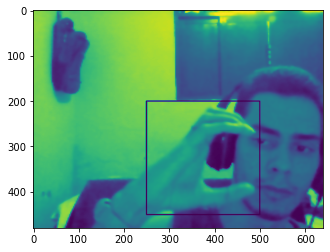

In [6]:
i = 8200
res = dataset[i].reshape(dataset[i].shape[0],dataset[i].shape[1]).copy()
bbox = abs_bboxs[i]
res = cv.resize(res,(640,480),cv.INTER_CUBIC)
cv.rectangle(res,pt1=(bbox[0],bbox[1]),pt2=(bbox[2],bbox[3]),color=(0),thickness=2)
plt.imshow(res)

In [376]:
def resize_bbox(bbox,coef):
    bbox = list(bbox)
    centerx = bbox[0]/2
    centery = bbox[1]/2
    
    bbox[0] -= centerx
    bbox[1] -= centery

    bbox[0] *= coef
    bbox[1] *= coef

    bbox[0] += centerx
    bbox[1] += centery

    bbox[2] -= centerx
    bbox[3] -= centery

    bbox[2] *= coef
    bbox[3] *= coef
    
    bbox[0] = int(bbox[0])
    bbox[1] = int(bbox[1])
    bbox[2] = int(bbox[2]+centerx)
    bbox[3] = int(bbox[3]+centery)
    
    return bbox

1. calcular centro:
- x+w/2
- y+h/2
(2,3)

2. subtrai x,y do centro:
(2,3) - (3,5) = (-1,-2)

3. multiplica pela escala (0.5):
(-1,-2) * 0.5 = (-0.5,-1)

4. soma o centro:
(-0.5,-1)+(3,5) = (2.5,4)
                   

In [377]:
resized_bboxs = [resize_bbox(bbox,coef) for bbox in abs_bboxs]
print(resized_bboxs[0:10],coef)

[[0, 0, 112, 112], [0, 0, 112, 112], [0, 0, 112, 112], [0, 0, 112, 112], [0, 0, 112, 112], [0, 0, 112, 112], [0, 0, 112, 112], [0, 0, 112, 112], [0, 0, 112, 112], [0, 0, 112, 112]] 0.45


[217, 36, 330, 148]


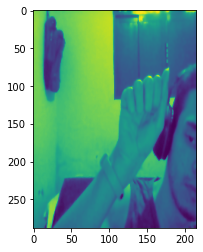

In [378]:
i = 1000
res = dataset[i].reshape((dataset[i].shape[0],dataset[i].shape[1])).copy()
bbox = resized_bboxs[i]
cv.rectangle(res,pt1=(bbox[0],bbox[1]),pt2=(bbox[2],bbox[3]),color=(0),thickness=2)
print(bbox)

plt.imshow(res)

In [7]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
scaled_bboxs = scaler.fit_transform(abs_bboxs)
print(scaled_bboxs[0:10])

[[-1.52723949 -1.41446617 -1.52723949 -1.41446617]
 [-1.52723949 -1.41446617 -1.52723949 -1.41446617]
 [-1.52723949 -1.41446617 -1.52723949 -1.41446617]
 [-1.52723949 -1.41446617 -1.52723949 -1.41446617]
 [-1.52723949 -1.41446617 -1.52723949 -1.41446617]
 [-1.52723949 -1.41446617 -1.52723949 -1.41446617]
 [-1.52723949 -1.41446617 -1.52723949 -1.41446617]
 [-1.52723949 -1.41446617 -1.52723949 -1.41446617]
 [-1.52723949 -1.41446617 -1.52723949 -1.41446617]
 [-1.52723949 -1.41446617 -1.52723949 -1.41446617]]


In [72]:
bbox_class_indexs = [i for i in range(len(dataset))]
print(len(bbox_class_indexs),dataset.shape)

8399 (8399, 288, 216, 1)


In [73]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(dataset, bbox_class_indexs, test_size=0.3)
print(X_train.shape,X_test.shape)

(5879, 288, 216, 1) (2520, 288, 216, 1)


In [74]:
y_train_bbox = np.array([scaled_bboxs[i] for i in y_train])
y_train_class = np.array([classes[i] for i in y_train])
print(y_train_class.shape,y_train_bbox.shape)

(5879, 3) (5879, 4)


In [77]:
y_test_bbox = np.array([scaled_bboxs[i] for i in y_test])
y_test_class = np.array([classes[i] for i in y_test])
print(y_test_class.shape,y_test_bbox.shape)

(2520, 3) (2520, 4)


In [78]:
SHAPE_CNN = (dataset[0].shape[0],dataset[0].shape[1],1)
OUTPUT_SHAPE = 3
LR = 0.00094

In [79]:
def feature_extractor(inputs):
    x = tf.keras.layers.Conv2D(8,kernel_size=3,activation='relu',input_shape=(SHAPE_CNN[0],SHAPE_CNN[1],1),padding='same')(inputs)
    x = tf.keras.layers.MaxPool2D((2,2))(x)
    
    x = tf.keras.layers.Conv2D(16,kernel_size=3,activation='relu',padding='same')(x)
    x = tf.keras.layers.MaxPool2D((2,2))(x)
    
    x = tf.keras.layers.Conv2D(32,kernel_size=3,activation='relu',padding='same')(x)
    x = tf.keras.layers.MaxPool2D((2,2))(x)
    
    x = tf.keras.layers.Conv2D(64,kernel_size=3,activation='relu',padding='same')(x)
    x = tf.keras.layers.MaxPool2D((2,2))(x)

    x = tf.keras.layers.Conv2D(128,kernel_size=3,activation='relu',padding='same')(x)
    x = tf.keras.layers.MaxPool2D((2,2))(x)
    
    return x

def hidden_layers(inputs):
    x = tf.keras.layers.Flatten()(inputs)
    x = tf.keras.layers.Dense(128,activation='relu')(x)
    x = tf.keras.layers.Dense(64,activation='relu')(x)
    x = tf.keras.layers.Dense(32,activation='relu')(x)
    x = tf.keras.layers.Dense(16,activation='relu')(x)
    
    return x

def classifier(inputs):
    classification = tf.keras.layers.Dense(OUTPUT_SHAPE,activation='sigmoid',name='classification')(inputs)
    
    return classification

def bounding_box_regression(inputs):
    bounding_box_regression_output = tf.keras.layers.Dense(units = '4', name = 'bounding_box')(inputs)
    return bounding_box_regression_output

In [80]:
def final_model(inputs):
    cnn_layer = feature_extractor(inputs)
    dense_layers = hidden_layers(cnn_layer)
    classification_layer = classifier(dense_layers)
    bbox_regression = bounding_box_regression(dense_layers)
    
    model = tf.keras.Model(inputs=inputs, outputs=[classification_layer,bbox_regression])
    return model

def define_and_compile_model(inputs):
    from tensorflow.keras.optimizers import SGD
    from tensorflow.keras.optimizers import Adam
    
    model = final_model(inputs)
    model.compile(
        optimizer=Adam(learning_rate=LR),
        loss = {'classification' : 'binary_crossentropy',
                      'bounding_box' : 'mse'
                     },
              metrics = {'classification' : 'accuracy',
                         'bounding_box' : 'mse'
                        }
    )
    return model

In [81]:
inputs = tf.keras.layers.Input(shape=(SHAPE_CNN[0],SHAPE_CNN[1],1))
model = define_and_compile_model(inputs)

model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 288, 216, 1) 0                                            
__________________________________________________________________________________________________
conv2d_5 (Conv2D)               (None, 288, 216, 8)  80          input_2[0][0]                    
__________________________________________________________________________________________________
max_pooling2d_5 (MaxPooling2D)  (None, 144, 108, 8)  0           conv2d_5[0][0]                   
__________________________________________________________________________________________________
conv2d_6 (Conv2D)               (None, 144, 108, 16) 1168        max_pooling2d_5[0][0]            
____________________________________________________________________________________________

In [ ]:
model.fit(X_train,(y_train_class,y_train_bbox),epochs=10)

Epoch 1/10
184/184 [==============================] - 105s 564ms/step - loss: 2.8966 - classification_loss: 0.7785 - bounding_box_loss: 2.1181 - classification_accuracy: 0.5043 - bounding_box_mse: 2.1181
Epoch 2/10
184/184 [==============================] - 112s 607ms/step - loss: 0.5871 - classification_loss: 0.3288 - bounding_box_loss: 0.2583 - classification_accuracy: 0.8238 - bounding_box_mse: 0.2583
Epoch 3/10
184/184 [==============================] - 117s 635ms/step - loss: 0.3335 - classification_loss: 0.2075 - bounding_box_loss: 0.1261 - classification_accuracy: 0.9864 - bounding_box_mse: 0.1261
Epoch 4/10
184/184 [==============================] - 119s 649ms/step - loss: 0.2566 - classification_loss: 0.1730 - bounding_box_loss: 0.0836 - classification_accuracy: 0.9990 - bounding_box_mse: 0.0836
Epoch 5/10
104/184 [===============>..............] - ETA: 52s - loss: 0.2285 - classification_loss: 0.1587 - bounding_box_loss: 0.0697 - classification_accuracy: 0.9994 - bounding_box

In [30]:
X_test.shape

(2520, 288, 216, 1)

In [62]:
predictions_classes,predictions_bboxs = model.predict(X_test)
print(predictions_classes.shape,predictions_bboxs.shape)

(2520, 3) (2520, 4)


In [63]:
bboxs_norm = []
for i in predictions_bboxs:
    bboxs_norm.append(scaler.inverse_transform(i).astype(int))
bboxs_norm = np.array(bboxs_norm)
print(bboxs_norm.shape)

(2520, 4)


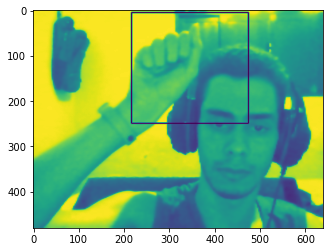

In [70]:
i = 2500
res = X_test[i].reshape(X_test[i].shape[0],X_test[i].shape[1]).copy()
res = cv.resize(res,(640,480),cv.INTER_CUBIC)
bbox = bboxs_norm[i]

cv.rectangle(res,pt1=(bbox[0],bbox[1]),pt2=(bbox[2],bbox[3]),color=(0),thickness=2)
plt.imshow(res)

In [66]:
from sklearn.metrics import classification_report

#y_test_class = [np.argmax(i) for i in y_test_class]
predictions = [np.argmax(i) for i in predictions_classes]

print(classification_report(y_test_class,predictions))

              precision    recall  f1-score   support

           0       1.00      0.33      0.49      2520
           1       0.00      0.00      0.00         0
           2       0.00      0.00      0.00         0

    accuracy                           0.33      2520
   macro avg       0.33      0.11      0.16      2520
weighted avg       1.00      0.33      0.49      2520



/home/rene/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/rene/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/rene/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [68]:
print(y_test_bbox.shape,predictions_bboxs.shape)

(2520, 4) (2520, 4)


In [69]:
from sklearn.metrics import mean_squared_error
from math import sqrt

rmse = sqrt(mean_squared_error(predictions_bboxs,y_test_bbox))
print(rmse)

0.16172335918636316


In [52]:
tf.keras.models.save_model(model,"Models/model_loc2.h5")